# Imports

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tp_models import init_denoising, pnp_pgd_denoising, red_denoising, crr_nn_denoising, psnr

import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [10]:
!wget https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
!unzip tp9.zip
!rm -r im
!rm tp9.zip

--2025-03-21 19:57:25--  https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
Résolution de perso.telecom-paristech.fr (perso.telecom-paristech.fr)… 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connexion à perso.telecom-paristech.fr (perso.telecom-paristech.fr)|2a04:8ec0:0:a::89c2:16e3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 501814458 (479M) [application/zip]
Sauvegarde en : « tp9.zip »

tp9.zip             100%[===================>] 478,57M  38,1MB/s    ds 15s     

2025-03-21 19:57:40 (32,8 MB/s) — « tp9.zip » sauvegardé [501814458/501814458]

Archive:  tp9.zip
replace ckpts/drunet_color.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

OSError: [Errno 5] Input/output error

# Experiments

# Noising

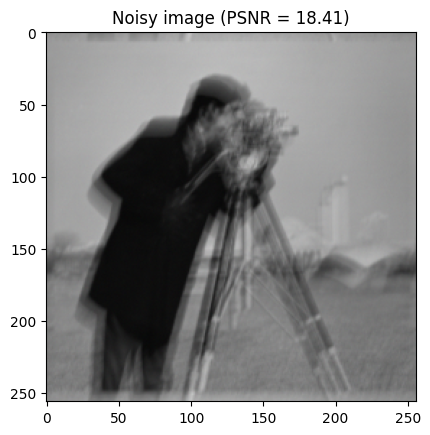

In [44]:
image, _, noisy_image, _ = init_denoising("images/photographer.png")

image = image.squeeze().permute(1, 2, 0)
noisy_image = noisy_image.squeeze().permute(1, 2, 0)

noisy_psnr = psnr(image, noisy_image)

plt.title(f"Noisy image (PSNR = {noisy_psnr:.2f})")
plt.imshow(noisy_image.cpu(), cmap='gray')

## PNP-PGD

[   0/ 100] [0.00000 s] PSNR = 18.41
[  10/ 100] [0.14881 s] PSNR = 25.02
[  20/ 100] [0.28863 s] PSNR = 26.78
[  30/ 100] [0.42255 s] PSNR = 27.83
[  40/ 100] [0.55837 s] PSNR = 28.59
[  50/ 100] [0.69492 s] PSNR = 29.16
[  60/ 100] [0.82943 s] PSNR = 29.61
[  70/ 100] [0.96402 s] PSNR = 29.95
[  80/ 100] [1.09890 s] PSNR = 30.21
[  90/ 100] [1.23318 s] PSNR = 30.41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002552772..1.0157235].


[ 100/ 100] [1.36747 s] PSNR = 30.56


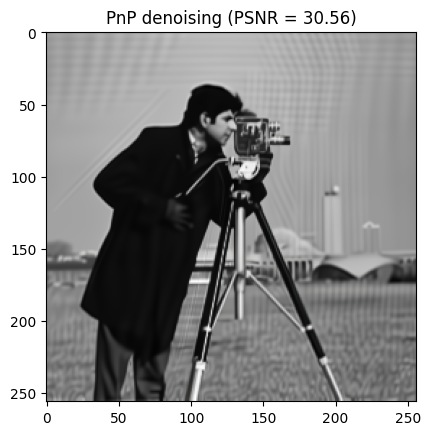

In [45]:
x_pnp, psnr_pnp = pnp_pgd_denoising("images/photographer.png", niter=100)

plt.title(f"PnP denoising (PSNR = {psnr_pnp:.2f})")
plt.imshow(x_pnp, cmap='gray')

## RED-PGD

[   0/ 100] [0.00000 s] PSNR = 18.41
[  10/ 100] [0.28866 s] PSNR = 23.90
[  20/ 100] [0.56975 s] PSNR = 25.81
[  30/ 100] [0.85083 s] PSNR = 26.88
[  40/ 100] [1.13304 s] PSNR = 27.57
[  50/ 100] [1.41492 s] PSNR = 28.05
[  60/ 100] [1.69703 s] PSNR = 28.39
[  70/ 100] [1.97944 s] PSNR = 28.62
[  80/ 100] [2.26182 s] PSNR = 28.79
[  90/ 100] [2.54346 s] PSNR = 28.90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.093613595..1.0651605].


[ 100/ 100] [2.82452 s] PSNR = 28.96


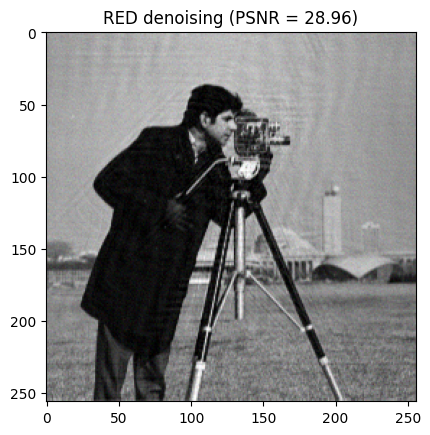

In [46]:
x_red, psnr_red = red_denoising("images/photographer.png", niter=100)

plt.title(f"RED denoising (PSNR = {psnr_red:.2f})")
plt.imshow(x_red)

## CRR-NN

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


  0%|          | 0/100 [00:00<?, ?it/s]/home/mml/Documents/GMI/.pixi/envs/default/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/home/mml/Documents/GMI/.pixi/envs/default/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
psnr: 37.87 | ssim: 0.9578 | res: 5.47e-05: 100%|██████████| 100/100 [00:00<00:00, 226.45it/s]


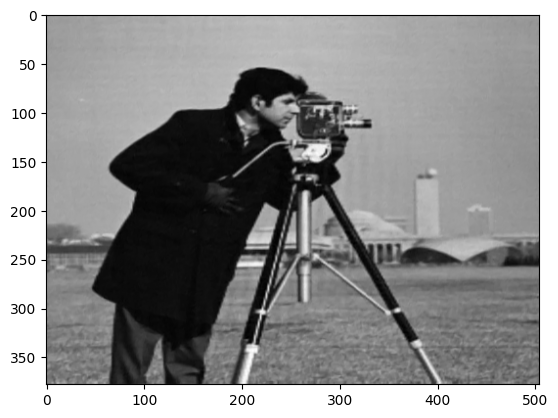

In [53]:
x_crr, psnr_crr = crr_nn_denoising("images/photographer.png", niter=100, lmbd=0.11, mu=10)
plt.imshow(x_crr.numpy(), cmap="gray")

### Fine-tuning

In [ ]:
lmbd_test = np.linspace(0.001, 10, 10)
lmbd_array = np.zeros((10, 10))

for i, lmbd_ in enumerate(lmbd_test):
    for j in range(10):
        x, psnr = crr_nn_denoising("images/photographer.png", niter=100, lmbd=lmbd_, mu=10)
        lmbd_array[i, j] = psnr

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.39 | ssim: 0.7806 | res: 1.24e-02:   0%|          | 0/100 [00:00<?, ?it/s]

psnr: 29.51 | ssim: 0.6527 | res: 1.40e-04: 100%|██████████| 100/100 [00:00<00:00, 223.11it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.28 | ssim: 0.6313 | res: 1.82e-04: 100%|██████████| 100/100 [00:00<00:00, 232.83it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.41 | ssim: 0.6471 | res: 1.38e-04: 100%|██████████| 100/100 [00:00<00:00, 235.85it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.45 | ssim: 0.6371 | res: 1.66e-04: 100%|██████████| 100/100 [00:00<00:00, 231.22it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.61 | ssim: 0.6531 | res: 2.82e-04: 100%|██████████| 100/100 [00:00<00:00, 233.50it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.46 | ssim: 0.6484 | res: 9.60e-05: 100%|██████████| 100/100 [00:00<00:00, 232.12it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.53 | ssim: 0.6507 | res: 2.46e-04: 100%|██████████| 100/100 [00:00<00:00, 235.62it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.49 | ssim: 0.6457 | res: 1.39e-04: 100%|██████████| 100/100 [00:00<00:00, 235.92it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.36 | ssim: 0.6336 | res: 1.15e-04: 100%|██████████| 100/100 [00:00<00:00, 234.42it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 29.43 | ssim: 0.6462 | res: 3.92e-04: 100%|██████████| 100/100 [00:00<00:00, 235.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.77 | ssim: 0.8907 | res: 6.51e-04: 100%|██████████| 100/100 [00:00<00:00, 234.34it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.80 | ssim: 0.8896 | res: 2.66e-04: 100%|██████████| 100/100 [00:00<00:00, 231.83it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.80 | ssim: 0.8904 | res: 6.74e-04: 100%|██████████| 100/100 [00:00<00:00, 236.58it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.72 | ssim: 0.8892 | res: 2.90e-04: 100%|██████████| 100/100 [00:00<00:00, 232.89it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.81 | ssim: 0.8905 | res: 1.09e-04: 100%|██████████| 100/100 [00:00<00:00, 236.60it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.80 | ssim: 0.8898 | res: 1.46e-04: 100%|██████████| 100/100 [00:00<00:00, 230.95it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.83 | ssim: 0.8905 | res: 1.89e-04: 100%|██████████| 100/100 [00:00<00:00, 234.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.79 | ssim: 0.8901 | res: 3.63e-04: 100%|██████████| 100/100 [00:00<00:00, 235.43it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.69 | ssim: 0.8883 | res: 6.39e-04: 100%|██████████| 100/100 [00:00<00:00, 233.23it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 30.75 | ssim: 0.8898 | res: 2.46e-04: 100%|██████████| 100/100 [00:00<00:00, 235.72it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.51 | ssim: 0.8492 | res: 1.34e-04: 100%|██████████| 100/100 [00:00<00:00, 235.63it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.33 | ssim: 0.8467 | res: 6.41e-04: 100%|██████████| 100/100 [00:00<00:00, 236.62it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.37 | ssim: 0.8467 | res: 1.65e-04: 100%|██████████| 100/100 [00:00<00:00, 236.05it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.37 | ssim: 0.8470 | res: 1.14e-04: 100%|██████████| 100/100 [00:00<00:00, 235.69it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.38 | ssim: 0.8473 | res: 4.38e-04: 100%|██████████| 100/100 [00:00<00:00, 232.62it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.39 | ssim: 0.8473 | res: 5.81e-04: 100%|██████████| 100/100 [00:00<00:00, 236.78it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.46 | ssim: 0.8483 | res: 5.31e-04: 100%|██████████| 100/100 [00:00<00:00, 235.55it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.47 | ssim: 0.8482 | res: 6.06e-04: 100%|██████████| 100/100 [00:00<00:00, 233.50it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.33 | ssim: 0.8463 | res: 9.73e-05: 100%|██████████| 100/100 [00:00<00:00, 234.53it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 28.39 | ssim: 0.8476 | res: 2.10e-04: 100%|██████████| 100/100 [00:00<00:00, 231.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.27 | ssim: 0.8222 | res: 2.19e-04: 100%|██████████| 100/100 [00:00<00:00, 233.54it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.09 | ssim: 0.8197 | res: 4.04e-04: 100%|██████████| 100/100 [00:00<00:00, 233.19it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.16 | ssim: 0.8204 | res: 6.29e-04: 100%|██████████| 100/100 [00:00<00:00, 233.78it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.16 | ssim: 0.8204 | res: 7.49e-05: 100%|██████████| 100/100 [00:00<00:00, 234.39it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.26 | ssim: 0.8223 | res: 1.10e-04: 100%|██████████| 100/100 [00:00<00:00, 232.11it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.27 | ssim: 0.8220 | res: 5.76e-04: 100%|██████████| 100/100 [00:00<00:00, 232.31it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.06 | ssim: 0.8183 | res: 3.51e-04: 100%|██████████| 100/100 [00:00<00:00, 231.41it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.17 | ssim: 0.8206 | res: 6.30e-04: 100%|██████████| 100/100 [00:00<00:00, 236.11it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.26 | ssim: 0.8223 | res: 7.36e-04: 100%|██████████| 100/100 [00:00<00:00, 235.74it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 27.24 | ssim: 0.8216 | res: 6.01e-04: 100%|██████████| 100/100 [00:00<00:00, 236.57it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.30 | ssim: 0.8010 | res: 2.51e-04: 100%|██████████| 100/100 [00:00<00:00, 236.02it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.35 | ssim: 0.8017 | res: 9.69e-05: 100%|██████████| 100/100 [00:00<00:00, 235.24it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.26 | ssim: 0.8000 | res: 3.94e-04: 100%|██████████| 100/100 [00:00<00:00, 234.90it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.36 | ssim: 0.8021 | res: 3.24e-04: 100%|██████████| 100/100 [00:00<00:00, 236.01it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.43 | ssim: 0.8036 | res: 1.24e-04: 100%|██████████| 100/100 [00:00<00:00, 235.66it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.38 | ssim: 0.8023 | res: 8.29e-05: 100%|██████████| 100/100 [00:00<00:00, 236.75it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.41 | ssim: 0.8030 | res: 3.99e-04: 100%|██████████| 100/100 [00:00<00:00, 236.38it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.37 | ssim: 0.8022 | res: 1.09e-03: 100%|██████████| 100/100 [00:00<00:00, 237.60it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.36 | ssim: 0.8020 | res: 1.75e-04: 100%|██████████| 100/100 [00:00<00:00, 233.35it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 26.35 | ssim: 0.8017 | res: 1.94e-04: 100%|██████████| 100/100 [00:00<00:00, 237.54it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.84 | ssim: 0.7890 | res: 3.33e-04: 100%|██████████| 100/100 [00:00<00:00, 235.63it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.77 | ssim: 0.7878 | res: 1.21e-04: 100%|██████████| 100/100 [00:00<00:00, 233.86it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.73 | ssim: 0.7870 | res: 6.47e-05: 100%|██████████| 100/100 [00:00<00:00, 236.71it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.80 | ssim: 0.7884 | res: 9.85e-04: 100%|██████████| 100/100 [00:00<00:00, 236.38it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.84 | ssim: 0.7891 | res: 5.29e-04: 100%|██████████| 100/100 [00:00<00:00, 234.43it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.80 | ssim: 0.7884 | res: 4.22e-04: 100%|██████████| 100/100 [00:00<00:00, 236.46it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.80 | ssim: 0.7883 | res: 1.51e-04: 100%|██████████| 100/100 [00:00<00:00, 235.44it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.73 | ssim: 0.7871 | res: 8.90e-04: 100%|██████████| 100/100 [00:00<00:00, 233.13it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.78 | ssim: 0.7880 | res: 2.81e-04: 100%|██████████| 100/100 [00:00<00:00, 232.78it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.81 | ssim: 0.7884 | res: 8.24e-04: 100%|██████████| 100/100 [00:00<00:00, 233.21it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.33 | ssim: 0.7773 | res: 3.38e-04: 100%|██████████| 100/100 [00:00<00:00, 232.60it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.29 | ssim: 0.7766 | res: 8.46e-05: 100%|██████████| 100/100 [00:00<00:00, 232.97it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.26 | ssim: 0.7761 | res: 6.75e-05: 100%|██████████| 100/100 [00:00<00:00, 232.21it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.33 | ssim: 0.7775 | res: 7.55e-04: 100%|██████████| 100/100 [00:00<00:00, 234.16it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.30 | ssim: 0.7768 | res: 7.05e-05: 100%|██████████| 100/100 [00:00<00:00, 234.59it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.26 | ssim: 0.7759 | res: 1.13e-04: 100%|██████████| 100/100 [00:00<00:00, 233.23it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.37 | ssim: 0.7781 | res: 8.27e-04: 100%|██████████| 100/100 [00:00<00:00, 233.19it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.34 | ssim: 0.7775 | res: 6.96e-04: 100%|██████████| 100/100 [00:00<00:00, 230.74it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.26 | ssim: 0.7760 | res: 2.34e-04: 100%|██████████| 100/100 [00:00<00:00, 234.61it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.38 | ssim: 0.7784 | res: 8.13e-04: 100%|██████████| 100/100 [00:00<00:00, 234.18it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.97 | ssim: 0.7687 | res: 2.48e-04: 100%|██████████| 100/100 [00:00<00:00, 226.16it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.02 | ssim: 0.7699 | res: 5.63e-04: 100%|██████████| 100/100 [00:00<00:00, 231.88it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.98 | ssim: 0.7689 | res: 1.18e-04: 100%|██████████| 100/100 [00:00<00:00, 229.04it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.96 | ssim: 0.7686 | res: 1.89e-04: 100%|██████████| 100/100 [00:00<00:00, 236.99it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.96 | ssim: 0.7686 | res: 6.90e-04: 100%|██████████| 100/100 [00:00<00:00, 237.22it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.04 | ssim: 0.7701 | res: 9.51e-04: 100%|██████████| 100/100 [00:00<00:00, 234.26it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.98 | ssim: 0.7690 | res: 5.78e-04: 100%|██████████| 100/100 [00:00<00:00, 236.28it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.91 | ssim: 0.7676 | res: 9.83e-05: 100%|██████████| 100/100 [00:00<00:00, 236.59it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.04 | ssim: 0.7700 | res: 7.53e-05: 100%|██████████| 100/100 [00:00<00:00, 231.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 25.05 | ssim: 0.7703 | res: 8.06e-05: 100%|██████████| 100/100 [00:00<00:00, 232.97it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.72 | ssim: 0.7626 | res: 3.89e-04: 100%|██████████| 100/100 [00:00<00:00, 232.02it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.74 | ssim: 0.7630 | res: 4.08e-04: 100%|██████████| 100/100 [00:00<00:00, 232.95it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.76 | ssim: 0.7633 | res: 1.42e-04: 100%|██████████| 100/100 [00:00<00:00, 232.14it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.71 | ssim: 0.7623 | res: 1.44e-04: 100%|██████████| 100/100 [00:00<00:00, 232.62it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.75 | ssim: 0.7630 | res: 7.05e-04: 100%|██████████| 100/100 [00:00<00:00, 232.53it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.73 | ssim: 0.7628 | res: 3.46e-04: 100%|██████████| 100/100 [00:00<00:00, 233.92it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.71 | ssim: 0.7622 | res: 1.38e-04: 100%|██████████| 100/100 [00:00<00:00, 235.94it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.73 | ssim: 0.7628 | res: 4.00e-04: 100%|██████████| 100/100 [00:00<00:00, 237.13it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.73 | ssim: 0.7628 | res: 6.71e-05: 100%|██████████| 100/100 [00:00<00:00, 235.84it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.76 | ssim: 0.7632 | res: 6.99e-04: 100%|██████████| 100/100 [00:00<00:00, 237.28it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.47 | ssim: 0.7565 | res: 5.31e-04: 100%|██████████| 100/100 [00:00<00:00, 230.29it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.52 | ssim: 0.7575 | res: 8.27e-05: 100%|██████████| 100/100 [00:00<00:00, 235.71it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.48 | ssim: 0.7567 | res: 3.75e-04: 100%|██████████| 100/100 [00:00<00:00, 231.13it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.49 | ssim: 0.7569 | res: 2.03e-04: 100%|██████████| 100/100 [00:00<00:00, 233.04it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.49 | ssim: 0.7569 | res: 2.40e-04: 100%|██████████| 100/100 [00:00<00:00, 233.22it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.47 | ssim: 0.7563 | res: 2.37e-04: 100%|██████████| 100/100 [00:00<00:00, 231.95it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.49 | ssim: 0.7569 | res: 3.52e-04: 100%|██████████| 100/100 [00:00<00:00, 236.74it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.57 | ssim: 0.7584 | res: 3.19e-04: 100%|██████████| 100/100 [00:00<00:00, 233.39it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.50 | ssim: 0.7571 | res: 1.03e-04: 100%|██████████| 100/100 [00:00<00:00, 232.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 24.50 | ssim: 0.7571 | res: 1.40e-04: 100%|██████████| 100/100 [00:00<00:00, 232.21it/s]


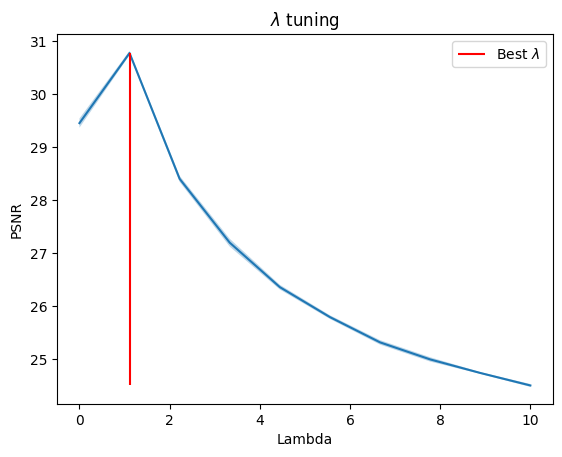

In [49]:
plt.figure()
plt.plot(lmbd_test, lmbd_array.mean(axis=1))
plt.fill_between(lmbd_test, lmbd_array.mean(axis=1) - lmbd_array.std(axis=1), lmbd_array.mean(axis=1) + lmbd_array.std(axis=1), alpha=0.3)
plt.xlabel("Lambda")
plt.ylabel("PSNR")
plt.title(r"$\lambda$ tuning")
plt.vlines(lmbd_test[np.argmax(lmbd_array.mean(axis=1))], lmbd_array.mean(axis=1).min(), lmbd_array.mean(axis=1).max(), color="red", label=r"Best $\lambda$")
plt.legend()
plt.show()

# Global results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002552772..1.0157235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.093613595..1.0651605].


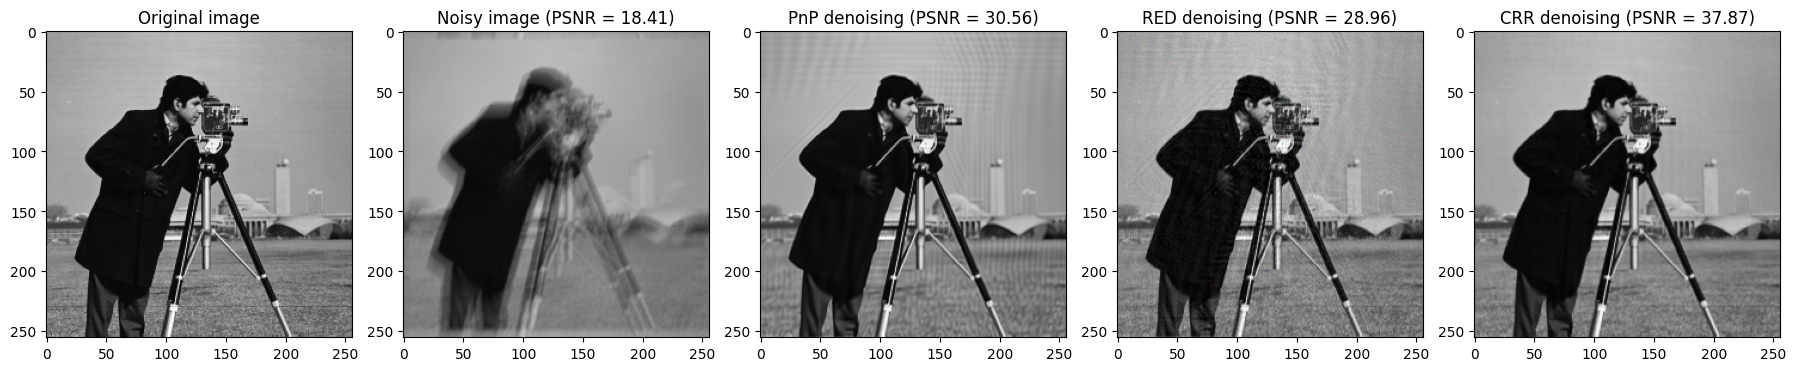

In [66]:
plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

plt.subplot(1, 5, 1)
plt.imshow(image.cpu(), cmap='gray')
plt.title("Original image")

plt.subplot(1, 5, 2)
plt.imshow(noisy_image.cpu(), cmap='gray')
plt.title(f"Noisy image (PSNR = {noisy_psnr:.2f})")

plt.subplot(1, 5, 3)
plt.imshow(x_pnp.cpu(), cmap='gray')
plt.title(f"PnP denoising (PSNR = {psnr_pnp:.2f})")

plt.subplot(1, 5, 4)
plt.imshow(x_red.cpu(), cmap='gray')
plt.title(f"RED denoising (PSNR = {psnr_red:.2f})")

plt.subplot(1, 5, 5)
x_crr_resized = cv2.resize(x_crr.numpy(), (256, 256))
plt.imshow(x_crr_resized, cmap='gray')
plt.title(f"CRR denoising (PSNR = {psnr_crr:.2f})")

plt.tight_layout()
plt.savefig("test.pdf")

<Figure size 640x480 with 0 Axes>